# Artificial Neural Network Project: Predicting Customer Churn

## Context

An important component of sustainable success for a business is customer turnover or 'churn'. If a business better understood which aspects of their service most influence this decision (i.e., leave or stay), then management can then concentrate limited resources on mitigating turnover and retaining profitable customers.

## Problem statement

Given a database of a bank's customers, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

## Data description

This open-source dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

## Data dictionary

Independent variables:
- CustomerId: Unique ID which is assigned to each customer
- Surname: Last name of the customer 
- CreditScore: Defines the credit history of the customer
- Geography: A customer’s location
- Gender: Gender of the customer   
- Age: Age of the customer    
- Tenure: The number of years that the customer has been with the bank
- NumOfProducts: The number of products that a customer has purchased through the bank
- Balance: Account balance
- HasCrCard: A categorical variable that identifies whether the customer has a credit card or not
- EstimatedSalary: Estimated salary 
- isActiveMember: A categorical variable that identifies whether the customer is an active member of the bank or not
  - An active member is determined subjectively by whether a customer uses bank products regularly, makes regular transactions, etc

Dependent variable:
- Exited: A categorical variable identifying whether the customer left the bank within six months or not. It can take two values:
  - 0=No ( Customer did not leave the bank )
  - 1=Yes ( Customer left the bank )



## Import the dataset

Import the data

In [1]:
#upload CSV file
from google.colab import files
files.upload()

Import libraries and settings

In [2]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn     
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve )
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import losses
from keras import Sequential
from keras import backend
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

In [3]:
import warnings
warnings.filterwarnings('ignore')

#format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded to 2 decimal places

In [4]:
#import dataset
data = pd.read_csv('Churn.csv')
#copy dataset to a new variable
df = data.copy()
#sample five random rows from dataset
df.sample(n=5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
578,579,15734674,Lin,593,France,Female,41,6,0.00,1,1,0,65170.66,0
6552,6553,15636407,Beatham,793,Germany,Female,34,5,127758.09,1,1,0,143357.03,0
8718,8719,15627298,Vinogradova,589,France,Male,37,7,85146.48,2,1,0,86490.09,1
7073,7074,15585855,Gould,679,France,Male,40,1,0.00,1,1,1,16897.19,0
1308,1309,15662294,Bennett,710,France,Male,33,10,118327.17,2,1,1,192928.82,0


In [5]:
#verify the version of TensorFlow
print(tf.__version__)

2.8.0


## User-defined functions

In [6]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="aqua"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [7]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
        
    ax = sns.countplot(
        data=data,
        x=feature,
        palette='viridis',
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotate the percentage

    plt.show()  # show the plot

## Overview of the dataset

In [8]:
#observe the shape of the dataframe
df.shape

(10000, 14)

In [9]:
#observe the data types, non-null values, and column names of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [10]:
#drop column RowNumber, CustomerId, and Surname from the dataset
df.drop(['RowNumber','CustomerId', 'Surname'], axis=1, inplace=True)

- *RowNumber*, *Customer_ID*, and *Surname* values should not provide any material information and will not be included in training the network.

In [11]:
#check for duplicate values
df[df.duplicated()].count()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [12]:
#convert all columns with dtype object into category
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

In [13]:
#convert all columns with dtype int64 into int32
for col in df.columns[df.dtypes=='int64']:
    df[col] = df[col].astype('int32')

In [14]:
#convert all columns with dtype float64 into float32
for col in df.columns[df.dtypes=='float64']:
    df[col] = df[col].astype('float32')

In [15]:
int_cat = ['HasCrCard','IsActiveMember']
#convert all columns in list to category
for col in int_cat:
    df[col] = df[col].astype('category')

In [16]:
#verify conversions
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      10000 non-null  int32   
 1   Geography        10000 non-null  category
 2   Gender           10000 non-null  category
 3   Age              10000 non-null  int32   
 4   Tenure           10000 non-null  int32   
 5   Balance          10000 non-null  float32 
 6   NumOfProducts    10000 non-null  int32   
 7   HasCrCard        10000 non-null  category
 8   IsActiveMember   10000 non-null  category
 9   EstimatedSalary  10000 non-null  float32 
 10  Exited           10000 non-null  int32   
dtypes: category(4), float32(2), int32(5)
memory usage: 313.1 KB


#### Observations
- The dataframe has 10000 rows and 11 columns.
- There are no duplicate values in the dataset.
- There are no null values across all columns.
- There are 4 columns of the dtype category, 2 columns of the dtype float64, and 5 columns of the dtype int64.
- The target variable for the Neural Network will be *Exited*.

## Univariate analysis

### Summary of float variables

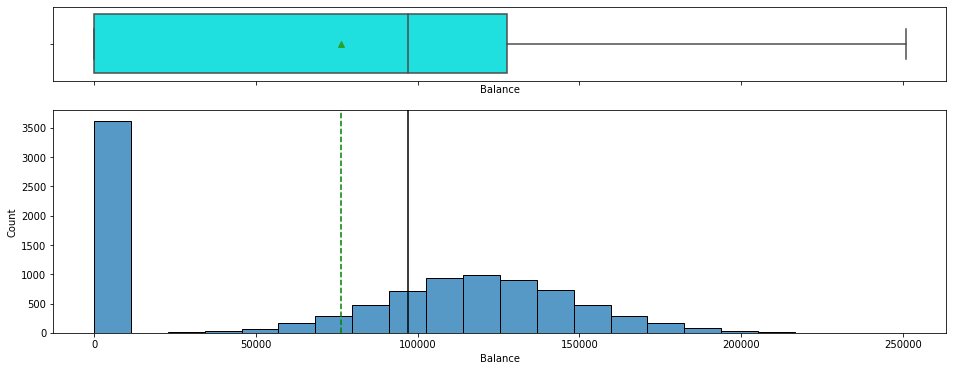

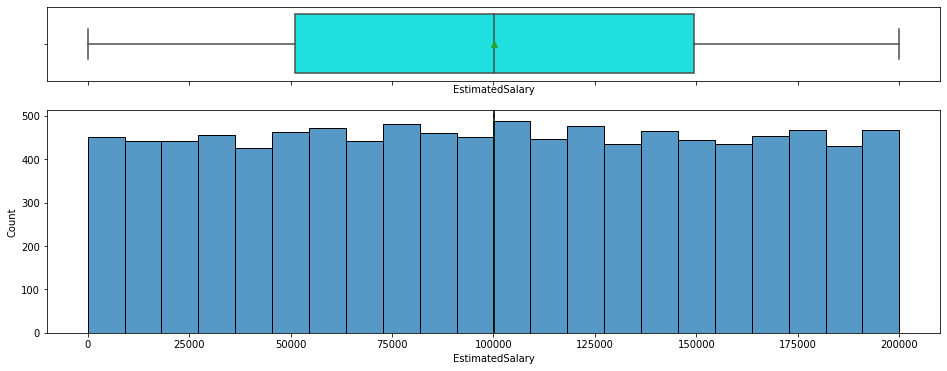

In [17]:
#plot all float32 variables
for col in df.columns[df.dtypes == 'float32']:
    histogram_boxplot(df, col)

In [18]:
#provide summary statistics of all float32 variables
df.describe(include = ['float32']).T

,count,mean,std,min,25%,50%,75%,max
Balance,10000.00,76485.78,62398.95,0.00,0.00,97198.54,127644.24,250898.09
EstimatedSalary,10000.00,100090.12,57510.47,11.58,51002.11,100193.91,149388.25,199992.48


In [19]:
#identify three categories of approximately equal size
print(df[df.Balance==0].shape[0])
print(df[df.Balance<120000].shape[0]-df[df.Balance==0].shape[0])
print(df[df.Balance>120000].shape[0])

3617
3202
3181


In [20]:
#identify a median balance
median_balance = 120000

#create bins
bins = [-1,1,median_balance,np.inf]

#create labels for each bin
category = ['<$1','$1-'+str(median_balance)[0:3]+'K','$'+str(median_balance)[0:3]+'K']

#cut all observations into one of three bins
df['Balance'] = pd.cut(df['Balance'], bins, labels=category)

In [21]:
#confirm transformation
df.Balance.value_counts()

<$1        3617
$1-120K    3202
$120K      3181
Name: Balance, dtype: int64

#### Observations
- The distribution for *Balance* appears highly left skewed, with 3617 people having a balance of $0 and the remaining cohort having a normal distribution of balances centered at approximately 120,000 dollars.
  - The information provided by this variable would be better served within the model by a categorical variable.
  - Based on my interpretation, this new variable should have values for a zero balance, a value for a balance below median, and a value for above median of this normal distribution.
- The distribution for "EstimatedSalary" appears relatively uniform between the minimum and maximum values of 12 dollars and 200,000 dollars, respectively.

### Summary of integer variables

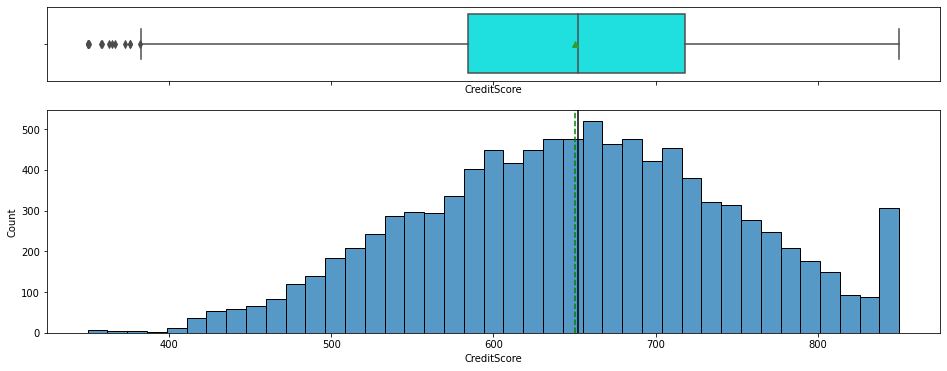

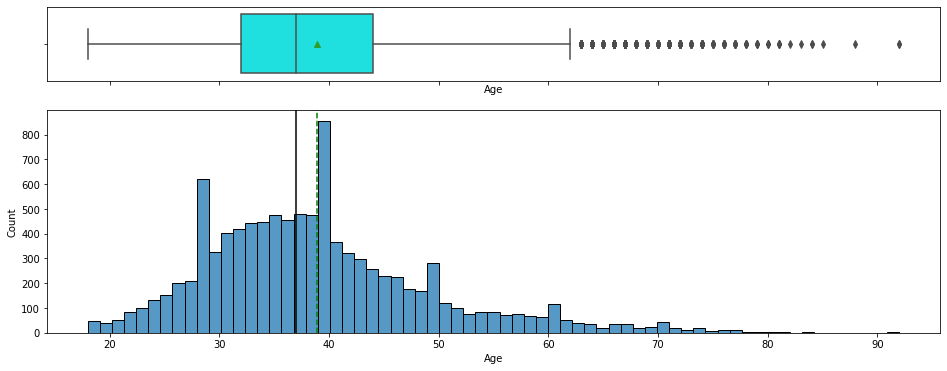

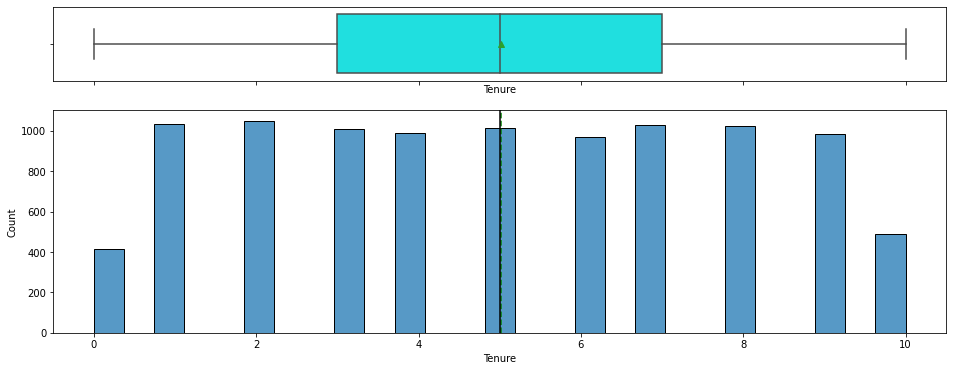

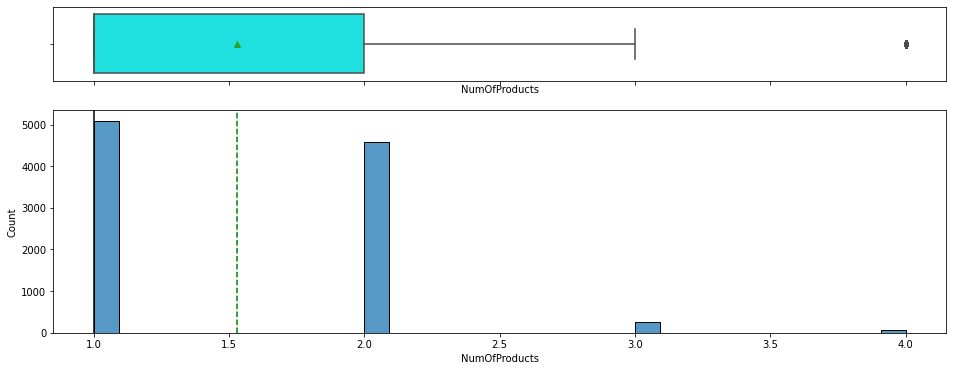

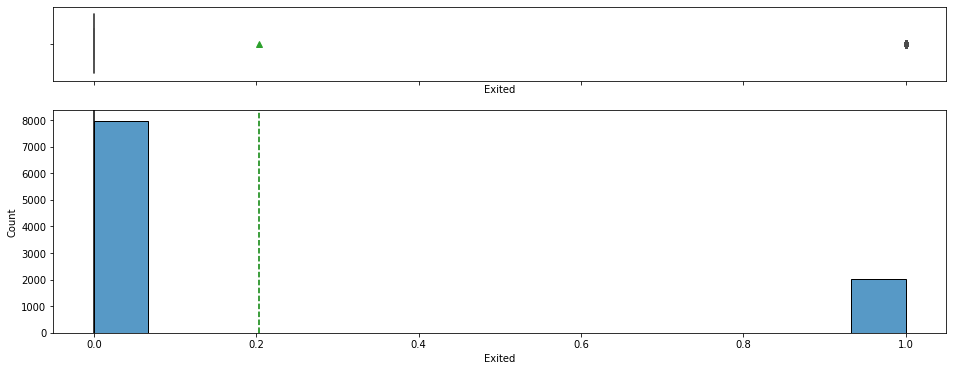

In [22]:
#plot all int32 variables
for col in df.columns[df.dtypes == 'int32']:
    histogram_boxplot(df, col)

In [23]:
#provide summary statistics of all int32 variables
df.describe(include = ['int32']).T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
NumOfProducts,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
Exited,10000.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00


In [24]:
#provide counts for all distinct values within each int32 variable
for col in df.columns[df.dtypes == 'int32']:
    print(df[col].value_counts())
    print(" ")

850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: CreditScore, Length: 460, dtype: int64
 
37    478
38    477
35    474
36    456
34    447
     ... 
92      2
82      1
88      1
85      1
83      1
Name: Age, Length: 70, dtype: int64
 
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64
 
1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64
 
0    7963
1    2037
Name: Exited, dtype: int64
 


#### Observations
- The distribution of *CreditScore* appears relatively normal, with a center with a mean credit score of 650 and an upper limit at 850.
- The distribution for *Age* appears right skewed, with a lower limit of 18, a mean age of 39, and a maximum age of 92.
- The distribution for *Tenure* appears uniform with, ~1000 people each between 1 and 9 years and half as many in the cohorts for 1 and 10 years with the bank.
- Only 326 of 10,000 people sampled have 3 or more products with the bank.

**Dependent variable**
- From the sample of 10,000 people, ~20% of customers subsequently left the bank.
- Further analysis on this variable is included below as part of the bivariate analysis.

### Summary of categorical variables

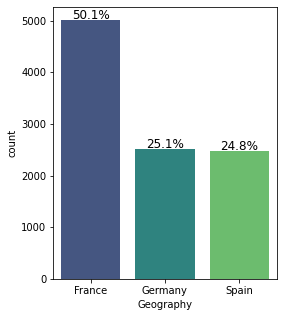

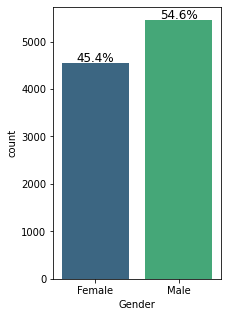

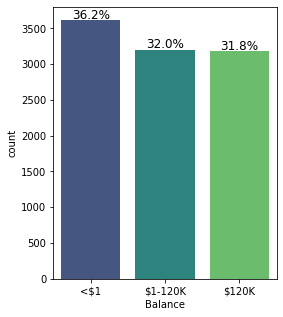

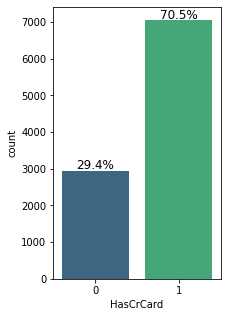

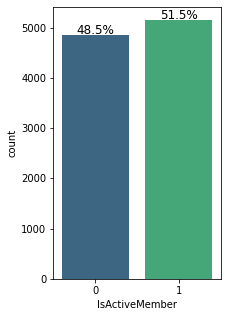

In [25]:
#provide boxplots of categorical variables
for col in df.columns[df.dtypes == 'category']:
    labeled_barplot(df, col, perc=True)

In [26]:
#provide descriptive statistics for categorical variables
df.describe(include = ['category']).T

,count,unique,top,freq
Geography,10000,3,France,5014
Gender,10000,2,Male,5457
Balance,10000,3,<$1,3617
HasCrCard,10000,2,1,7055
IsActiveMember,10000,2,1,5151


In [27]:
#provide counts for each unique variable in each categorical variable
for colname in df.dtypes[df.dtypes == 'category'].index:
    print(df[colname].value_counts(dropna=False))
    print(" ")

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
 
Male      5457
Female    4543
Name: Gender, dtype: int64
 
<$1        3617
$1-120K    3202
$120K      3181
Name: Balance, dtype: int64
 
1    7055
0    2945
Name: HasCrCard, dtype: int64
 
1    5151
0    4849
Name: IsActiveMember, dtype: int64
 


#### Observations
- Of the sample population of 10,000 bank account owners:
  - %55 are male
  - ~70% have a credit card
  - ~52% are active members (i.e., use the bank regularly)
  - 50% live in France, 25% live in Germany, and 25% live in Spain; so, the population is biased towards French people.


## Bivariate analysis

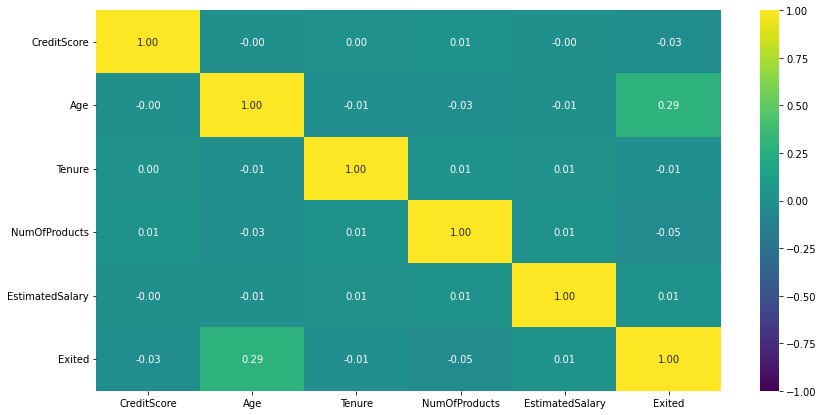

In [28]:
#create correlation heat map for numerical variables
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

#correlation heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(
    df[numeric_columns].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap='viridis'
)
plt.show()

In [29]:
#provide ratios of the dependent variable for all categorical variables
for col in df.columns[df.dtypes == 'category']:
    print(df.groupby(col)["Exited"].value_counts(normalize=True).mul(100))
    print(" ")

Geography  Exited
France     0        83.85
           1        16.15
Germany    0        67.56
           1        32.44
Spain      0        83.33
           1        16.67
Name: Exited, dtype: float64
 
Gender  Exited
Female  0        74.93
        1        25.07
Male    0        83.54
        1        16.46
Name: Exited, dtype: float64
 
Balance  Exited
<$1      0        86.18
         1        13.82
$1-120K  0        75.89
         1        24.11
$120K    0        75.95
         1        24.05
Name: Exited, dtype: float64
 
HasCrCard  Exited
0          0        79.19
           1        20.81
1          0        79.82
           1        20.18
Name: Exited, dtype: float64
 
IsActiveMember  Exited
0               0        73.15
                1        26.85
1               0        85.73
                1        14.27
Name: Exited, dtype: float64
 


In [30]:
#provide ratios of the dependent variable for all distinct values of Tenure
df.groupby('Tenure')["Exited"].value_counts(normalize=True).mul(100)

Tenure  Exited
0       0        77.00
        1        23.00
1       0        77.58
        1        22.42
2       0        80.82
        1        19.18
3       0        78.89
        1        21.11
4       0        79.47
        1        20.53
5       0        79.35
        1        20.65
6       0        79.73
        1        20.27
7       0        82.78
        1        17.22
8       0        80.78
        1        19.22
9       0        78.35
        1        21.65
10      0        79.39
        1        20.61
Name: Exited, dtype: float64

#### Observations
- The only variables which appear correlated are *Age* and *Exited*.
  - The low positive correlation signifies that, as a person ages, they are slightly more likely to leave the bank.
- A higher ratio of females in the population exited the bank than males.
- A higher ratio of people with a balance less than $1k in the population exited the bank than those with a balance greater than that amount.
- A lower ratio of people who were categorized as "Active Members" exited the bank than those who were not.
- Those with less than one year of tenure with the bank have the highest ratio of exits and those with only one year of tenure have the second highest ratio of exits.

## Preprocessing

In [31]:
#create dummy variables for the categorical features
df_train = pd.get_dummies(df,drop_first=True)

In [32]:
#review training data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int32  
 1   Age                10000 non-null  int32  
 2   Tenure             10000 non-null  int32  
 3   NumOfProducts      10000 non-null  int32  
 4   EstimatedSalary    10000 non-null  float32
 5   Exited             10000 non-null  int32  
 6   Geography_Germany  10000 non-null  uint8  
 7   Geography_Spain    10000 non-null  uint8  
 8   Gender_Male        10000 non-null  uint8  
 9   Balance_$1-120K    10000 non-null  uint8  
 10  Balance_$120K      10000 non-null  uint8  
 11  HasCrCard_1        10000 non-null  uint8  
 12  IsActiveMember_1   10000 non-null  uint8  
dtypes: float32(1), int32(5), uint8(7)
memory usage: 302.9 KB


In [33]:
#seperate features from labels
X = df_train.drop('Exited',axis=1)   # Predictor feature columns
Y = df_train['Exited']   # Predicted class (1=Exited, 0=Not Exited)

In [34]:
#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

- NOTE: Do not scale the dependent variable in a classification problem

In [35]:
#define scaler
scaler = preprocessing.StandardScaler()
#fit the scaler on the independent variables for both train and test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
#convert the data elements into tensors, as we need tensors for different tensorflow based operations
x_train1=tf.convert_to_tensor(X_train)
y_train1=tf.convert_to_tensor(y_train)
x_test1=tf.convert_to_tensor(X_test)
y_test1=tf.convert_to_tensor(y_test)

In [37]:
#print the shape of training tensors
print(x_train1.shape)
print(y_train1.shape)

#print the shape of training tensors
print(x_test1.shape)
print(y_test1.shape)

(8000, 12)
(8000,)
(2000, 12)
(2000,)


## Metric selection
AUC should be the target metric for the following reasons:
  - AUC provides an aggregate measure of performance across all possible classification thresholds.
  - AUC is scale-invariant (i.e., measures how well predictions are ranked, rather than their absolute values).
  - AUC is classification-threshold-invariant (i.e., measures the quality of the model’s predictions irrespective of what classification threshold is chosen).

In [38]:
#set the metric for training the ANNs
metric = tf.keras.metrics.AUC()

## Models 1 & 2: Baseline models

### Building

In [39]:
backend.clear_session()
#set the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [40]:
#set the layers within the neural network
model_1 = Sequential()
model_1.add(Dense(9, activation='relu',input_shape=(x_train1.shape[1],))) #input layer
model_1.add(Dense(6, activation='relu')) #hidden layer
model_1.add(Dense(1, activation='sigmoid')) #output layer

In [41]:
#set the optimizer, loss function, and metric
adam = Adam(learning_rate=1e-3)
model_1.compile(loss='binary_crossentropy', optimizer=adam, metrics=metric)

In [42]:
#show a summary of the ANN
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 117       
                                                                 
 dense_1 (Dense)             (None, 6)                 60        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 184
Trainable params: 184
Non-trainable params: 0
_________________________________________________________________


### Training

In [43]:
#train model across select number of epochs
epochs=30
history = model_1.fit(x_train1, y_train1, validation_split=0.2, epochs=epochs, verbose=0)

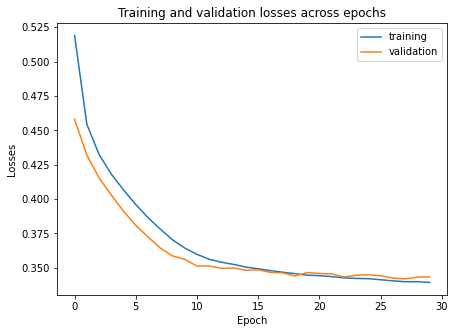

In [44]:
#plot progression of losses across training epochs
N = epochs
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, N), history.history["loss"], label="training")
plt.plot(np.arange(0, N), history.history["val_loss"], label="validation")

plt.title("Training and validation losses across epochs")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.legend(loc="best")
plt.show()

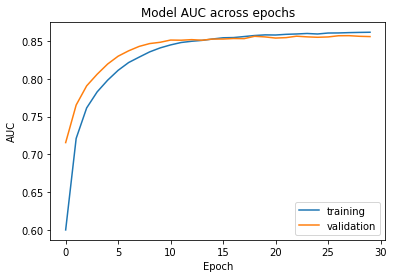

In [45]:
#plot progression of accuracy across training epochs
loss, accuracy  = model_1.evaluate(x_train1, y_train1, verbose=False)
    
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC across epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

- The ANN trained appears not to overfit the training data and to have reached a steady state of performance prior to the final epoch.

### Testing

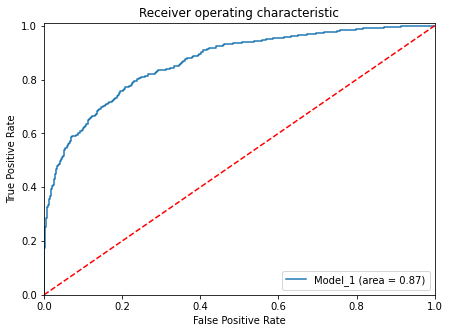

In [46]:
#plot ROC curve on testing data
roc_auc_test_1 = roc_auc_score(y_test1, model_1.predict(x_test1))
fpr, tpr, thresholds = roc_curve(y_test1, model_1.predict(x_test1))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Model_1 (area = %0.2f)" % roc_auc_test_1)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [47]:
#set baseline threshold
threshold = 0.5
#predict the labels of training data
y_pred_test1=np.round(model_1.predict(x_test1)>threshold,0).astype(int)

#generate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test1,y_pred_test1))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1585
           1       0.75      0.50      0.60       415

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



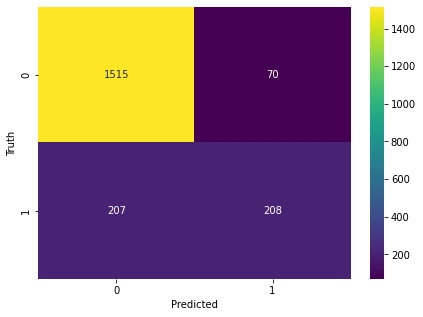

In [48]:
#create confusion matrix
cm=confusion_matrix(y_test1,y_pred_test1)

plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Optimal threshold

In [49]:
#optimal threshold as per AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test1, model_1.predict(x_test1))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.18896937


In [50]:
#set optimal threshold
threshold = optimal_threshold_auc_roc
#predict the labels of training data
y_pred_test2=np.round(model_1.predict(x_test1)>threshold,0).astype(int)

#generate classification report
print(classification_report(y_test1,y_pred_test2))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1585
           1       0.47      0.79      0.59       415

    accuracy                           0.78      2000
   macro avg       0.70      0.78      0.72      2000
weighted avg       0.84      0.78      0.79      2000



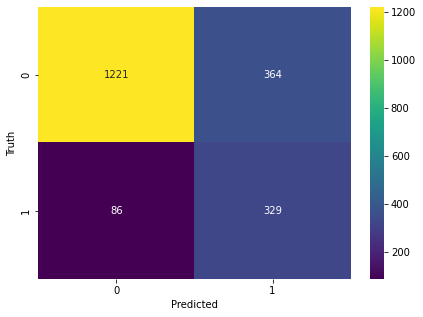

In [51]:
#create confusion matrix
cm=confusion_matrix(y_test1,y_pred_test2)

plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## Models 3 & 4: Additional layers

### Building

In [52]:
backend.clear_session()
#Setting the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [53]:
#select layers within the neural network
model_2 = Sequential()
model_2.add(Dense(12, activation='relu',input_shape=(x_train1.shape[1],))) #input layer
model_2.add(Dense(9, activation='relu')) #hidden layer
model_2.add(Dense(6, activation='relu')) #hidden layer
model_2.add(Dense(3, activation='relu')) #hidden layer
model_2.add(Dense(1, activation='sigmoid')) #output layer

In [54]:
#select optimizer, loss function, and target metric
adam = Adam(learning_rate=1e-3)
model_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=metric)

In [55]:
#provide summary of model
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 9)                 117       
                                                                 
 dense_2 (Dense)             (None, 6)                 60        
                                                                 
 dense_3 (Dense)             (None, 3)                 21        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 358
Trainable params: 358
Non-trainable params: 0
_________________________________________________________________


### Training

In [56]:
#train model across select number of epochs
epochs=30
history = model_2.fit(x_train1, y_train1, validation_split=0.2, epochs=epochs, verbose=0)

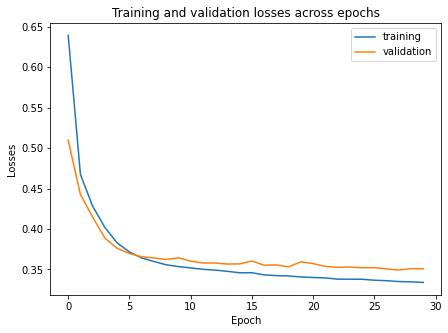

In [57]:
#plot progression of losses across training epochs
N = epochs
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, N), history.history["loss"], label="training")
plt.plot(np.arange(0, N), history.history["val_loss"], label="validation")

plt.title("Training and validation losses across epochs")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.legend(loc="best")
plt.show()

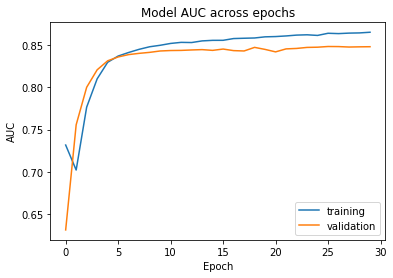

In [58]:
#plot progression of accuracy across training epochs
loss, accuracy  = model_2.evaluate(x_train1, y_train1, verbose=False)
    
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC across epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

- The ANN trained appears to minimally overfit the training data and to have reached a steady state of performance prior to the final epoch.

### Testing

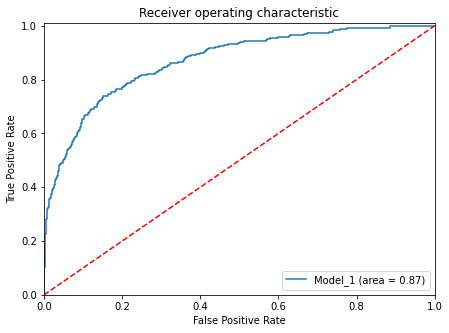

In [59]:
#plot ROC curve on testing data
roc_auc_test_2 = roc_auc_score(y_test1, model_2.predict(x_test1))
fpr, tpr, thresholds = roc_curve(y_test1, model_2.predict(x_test1))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Model_1 (area = %0.2f)" % roc_auc_test_2)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [60]:
#set baseline threshold
threshold = 0.5
#predict the labels of training data
y_pred_test3=np.round(model_2.predict(x_test1)>threshold,0).astype(int)

#generate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test1,y_pred_test3))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1585
           1       0.76      0.48      0.59       415

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



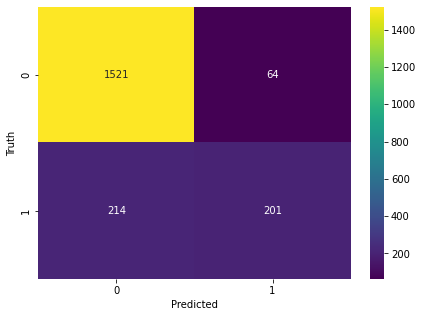

In [61]:
#create confusion matrix
cm=confusion_matrix(y_test1,y_pred_test3)

plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Optimization

In [62]:
#optimal threshold as per AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test1, model_2.predict(x_test1))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.2471463


In [63]:
#set optimal threshold
threshold = optimal_threshold_auc_roc
#predict the labels of training data
y_pred_test4=np.round(model_2.predict(x_test1)>threshold,0).astype(int)

#generate classification report
print(classification_report(y_test1,y_pred_test4))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89      1585
           1       0.56      0.73      0.64       415

    accuracy                           0.83      2000
   macro avg       0.74      0.79      0.76      2000
weighted avg       0.85      0.83      0.83      2000



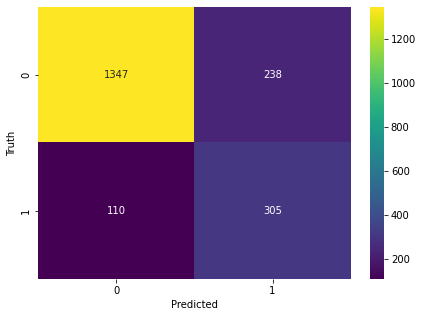

In [64]:
#create confusion matrix
cm=confusion_matrix(y_test1,y_pred_test4)

plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## Models 5 & 6: Incorporate batch normalization and dropout layers 

### Building

In [65]:
backend.clear_session()
#Setting the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [66]:
#select layers within the neural network
model_3 = Sequential()
model_3.add(Dense(12, activation='relu',input_shape=(x_train1.shape[1],))) #input layer
model_3.add(BatchNormalization()) #batch normalization
model_3.add(Dense(9, activation='relu')) #hidden layer
model_3.add(Dropout(0.1)) #dropout 10% of training data
model_3.add(BatchNormalization()) #batch normalization
model_3.add(Dense(6, activation='relu')) #hidden layer
model_3.add(BatchNormalization()) #batch normalization
model_3.add(Dropout(0.1)) #dropout 10% of training data
model_3.add(Dense(3, activation='relu')) #hidden layer
model_3.add(Dense(1, activation='sigmoid')) #output layer

In [67]:
#select optimizer, loss function, and target metric
adam = Adam(learning_rate=1e-3)
model_3.compile(loss='binary_crossentropy', optimizer=adam, metrics=metric)

In [68]:
#provide summary of model
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                156       
                                                                 
 batch_normalization (BatchN  (None, 12)               48        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 9)                 117       
                                                                 
 dropout (Dropout)           (None, 9)                 0         
                                                                 
 batch_normalization_1 (Batc  (None, 9)                36        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 6)                 6

### Training

In [69]:
#train model across select number of epochs
epochs=30
history = model_3.fit(x_train1, y_train1, validation_split=0.2, epochs=epochs, verbose=0)

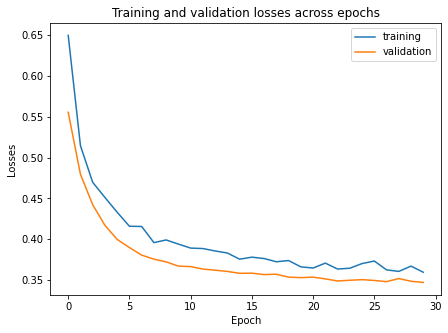

In [70]:
#plot progression of losses across training epochs
N = epochs
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, N), history.history["loss"], label="training")
plt.plot(np.arange(0, N), history.history["val_loss"], label="validation")

plt.title("Training and validation losses across epochs")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.legend(loc="best")
plt.show()

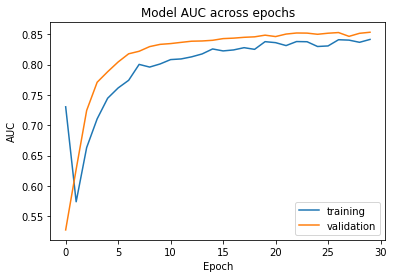

In [71]:
#plot progression of accuracy across training epochs
loss, accuracy  = model_3.evaluate(x_train1, y_train1, verbose=False)
    
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC across epochs')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

- The ANN trained appears to minimally overfit the training data and to have reached a steady state of performance prior to the final epoch.
- Additionally, the ANN appears to perform consistently better on the validation data than the training data across the epochs.

### Testing

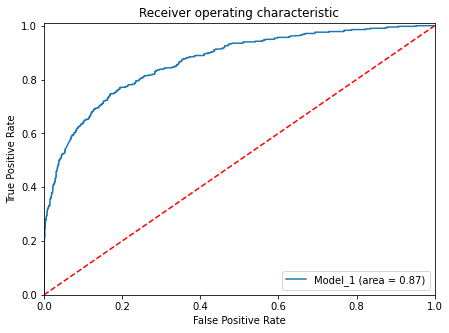

In [72]:
#plot ROC curve on testing data
roc_auc_test_3 = roc_auc_score(y_test1, model_3.predict(x_test1))
fpr, tpr, thresholds = roc_curve(y_test1, model_3.predict(x_test1))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Model_1 (area = %0.2f)" % roc_auc_test_3)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [73]:
#set baseline threshold
threshold = 0.5
#predict the labels of training data
y_pred_test5=np.round(model_3.predict(x_test1)>threshold,0).astype(int)

#generate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test1,y_pred_test5))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1585
           1       0.79      0.44      0.57       415

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.74      2000
weighted avg       0.85      0.86      0.84      2000



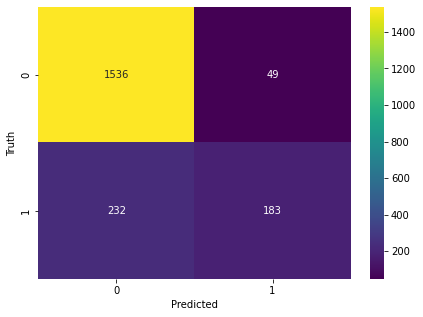

In [74]:
#create confusion matrix
cm=confusion_matrix(y_test1,y_pred_test5)

plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Optimization

In [75]:
#optimal threshold as per AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test1, model_3.predict(x_test1))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.21930292


In [76]:
#set optimal threshold
threshold = optimal_threshold_auc_roc
#predict the labels of training data
y_pred_test6=np.round(model_3.predict(x_test1)>threshold,0).astype(int)

#generate classification report
print(classification_report(y_test1,y_pred_test6))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1585
           1       0.53      0.74      0.62       415

    accuracy                           0.81      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.84      0.81      0.82      2000



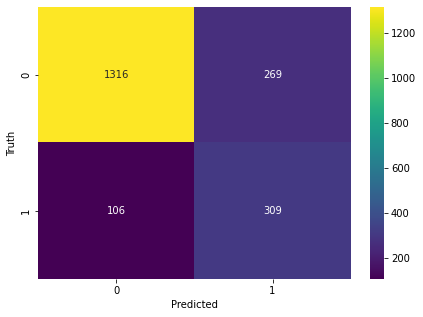

In [77]:
#create confusion matrix
cm=confusion_matrix(y_test1,y_pred_test6)

plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## Model 7 & 8: Randomized Search CV

- To implement a Randomized Search, we need to define a model function that can take in the hyper parameters. Note, we will use a Wrapper Class to integrate a NN model with Randomized Search.

In [78]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

rms = RMSprop()
sgd = SGD()
adam1 = Adam()

In [79]:
# ------------------- L1 Regularizer-----------------------

def build_model(n_hidden_layer=1, n_neurons=12, input_shape=X_train.shape[1], learning_rate=0.01, active="relu", drop=0.1, optimizers=adam1):

    # 1. Sequential model: create model; Initializes the model
    model = Sequential()
    
    model.add(keras.Input(shape=(input_shape,))) #specify the shape of input Layer
    
    #---------------------The number of neurons in layer n+1 is 2/3 * Number of neurons in layer n---------------
    
    for layer in range(n_hidden_layer):
        
        model.add(Dense(n_neurons, activation=active, kernel_regularizer=tf.keras.regularizers.L1(0.01)))

        if n_hidden_layer%2==0:
          
          model.add(Dropout(drop)) #Adding
        
        n_neurons=int(round(n_neurons*2/3))
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile model
    
    optimizer=optimizers

    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=metric) 
    
    return model

In [80]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
 
model_opt = KerasClassifier(build_fn=build_model, epochs=30, batch_size=32, verbose=0)

In [81]:
from sklearn.model_selection import RandomizedSearchCV

param_distribution = {
    "n_hidden_layer": [2,3,4,5],
    "n_neurons": [9,12,15,18],
    "active": ['relu', 'selu'],
    "learning_rate": [0.001,0.01],
    "optimizers":[adam1,sgd,rms]
}

#Randomized Search CV: K-fold cross-validation to determine the optimal hyperparameters

random_search_cv = RandomizedSearchCV(model_opt, param_distribution, n_iter=5, cv=3, scoring='f1', random_state=42)

random_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f41e80fded0>,
                   n_iter=5,
                   param_distributions={'active': ['relu', 'selu'],
                                        'learning_rate': [0.001, 0.01],
                                        'n_hidden_layer': [2, 3, 4, 5],
                                        'n_neurons': [9, 12, 15, 18],
                                        'optimizers': [<keras.optimizer_v2.adam.Adam object at 0x7f41562f5f50>,
                                                       <keras.optimizer_v2.rmsprop.RMSprop object at 0x7f41562f5210>]},
                   random_state=42, scoring='f1')

In [82]:
print("Best hyperparameters: %s" % (random_search_cv.best_params_))

Best hyperparameters: {'optimizers': <keras.optimizer_v2.rmsprop.RMSprop object at 0x7f41562f5210>, 'n_neurons': 18, 'n_hidden_layer': 5, 'learning_rate': 0.001, 'active': 'selu'}


In [83]:
model_tuned = random_search_cv.best_estimator_.model

### Testing

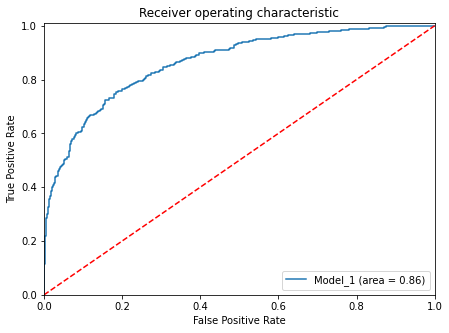

In [84]:
#plot ROC curve on testing data
roc_auc_test_4 = roc_auc_score(y_test1, model_tuned.predict(x_test1))
fpr, tpr, thresholds = roc_curve(y_test1, model_tuned.predict(x_test1))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Model_1 (area = %0.2f)" % roc_auc_test_4)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [85]:
#set baseline threshold
threshold = 0.5
#predict the labels of training data
y_pred_test7=np.round(model_tuned.predict(x_test1)>threshold,0).astype(int)

#generate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test1,y_pred_test7))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1585
           1       0.79      0.44      0.56       415

    accuracy                           0.86      2000
   macro avg       0.83      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



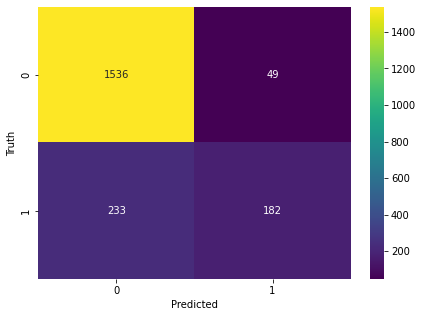

In [86]:
#create confusion matrix
cm=confusion_matrix(y_test1,y_pred_test7)

plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Optimization

In [87]:
#optimal threshold as per AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test1, model_tuned.predict(x_test1))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.17216419


In [88]:
#set optimal threshold
threshold = optimal_threshold_auc_roc
#predict the labels of training data
y_pred_test8=np.round(model_tuned.predict(x_test1)>threshold,0).astype(int)

#generate classification report
print(classification_report(y_test1,y_pred_test8))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1585
           1       0.52      0.75      0.61       415

    accuracy                           0.80      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.80      0.81      2000



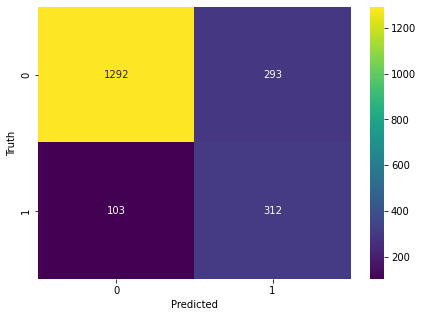

In [89]:
#create confusion matrix
cm=confusion_matrix(y_test1,y_pred_test8)

plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## Models summary

In [90]:
#list of predictions for all models generated
y_pred_tests = [y_pred_test1,y_pred_test2,y_pred_test3,y_pred_test4,y_pred_test5,y_pred_test6,y_pred_test7,y_pred_test8]

modelx = 1

#generate classification reports
for y_pred in y_pred_tests:
  print("Model "+str(modelx))
  print(classification_report(y_test1,y_pred))
  print(" ")
  modelx+=1

Model 1
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1585
           1       0.75      0.50      0.60       415

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000

 
Model 2
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1585
           1       0.47      0.79      0.59       415

    accuracy                           0.78      2000
   macro avg       0.70      0.78      0.72      2000
weighted avg       0.84      0.78      0.79      2000

 
Model 3
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1585
           1       0.76      0.48      0.59       415

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.85      0.86      0.85   

## Conclusions

**Criteria**
- My opinion of the best overall model is determined by the highest weighted average F1 score. This model provides the best combination of precision and recall across both possible outcomes.

- However, if the costs of attracting new customers outweights the costs of retaining an existing customer, then the best model would be the one which provides the highest F1 score for the prediciting an exiting customer (i.e., 1).

**Recommendation**
- Across all models with either a baseline (50%) threshold or the optimal threshold, I'd recommend the client select one of two models based on the preceding two rationales:
  - Model 1: KISS principle
    - The baseline model with a baseline threshold provides an equivalent F1 score, but, as a tie-breaker, also provides a minimally better score for exiting customers than Model 3.
  - Model 4: Find me the needles
    - With additional layers and an optimal threshold, this model provides the best capability of identifying an exiting customer amongst a population of all customers.